# 📔 About this notebook

PetFinder.my - Pawpularity Contest



## 📝 Memo

# 📚 Library

In [1]:
# General libraries
import collections
import gc
import glob
import json
import math
import os
import random
import re
import statistics
import sys
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import wandb
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [2]:
# Competition specific libraries
import albumentations as A
import cv2
import timm
from albumentations.pytorch import ToTensorV2

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# netrc = "/content/drive/MyDrive/.netrc" if 'google.colab' in sys.modules else "../input/wandbtoken/.netrc"
# !cp -f {netrc} ~/
!wandb login
wandb_tags = []

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [6]:
DATA_DIR = "../input/petfinder-pawpularity-score/"
OUTPUT_DIR = "./"
MODEL_DIR = "./models/"

!rm -rf {MODEL_DIR}

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [7]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submission.csv")

# TRAIN_IMAGE_PATH = DATA_DIR + "train/"
TRAIN_IMAGE_PATH = DATA_DIR + "crop/"
TEST_IMAGE_PATH = DATA_DIR + "test/"

# 🤔 Config

In [8]:
# seed = random.randrange(10000)
seed = 440
print(seed)

440


In [9]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "petfinder2"
    print_freq = 100

    train = True
    validate = False
    inference = False

    debug = False
    num_debug_data = 1000

    amp = True
    multi_gpu = True

Model list

- resnext50_32x4d
- vit_base_patch16_384
- tf_efficientnetv2_m_in21k
- swin_base_patch4_window12_384

In [10]:
config_defaults = {
    "seed": seed,
    "n_class": 1,
    "n_fold": 10,
    "epochs": 20,
    "es_patience": 10,
    "batch_size": 64,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "criterion": "BCEWithLogitsLoss",
    "optimizer": "Adam",
    "scheduler": "CosineAnnealingWarmRestarts",
    "lr": 1e-5,
    "min_lr": 1e-6,
    "weight_decay": 1e-7,
    "model_name": "swin_large_patch4_window12_384_in22k",
    "size": 384,
}

In [11]:
if Config.debug:
    config_defaults["n_fold"] = 3
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [12]:
if Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

else:
    wandb_job_type = ""

In [13]:
if Config.debug:
    wandb_tags.append("debug")

# if Config.amp:
#     wandb_tags.append("amp")

In [14]:
# wandb_tags.append("feats")
wandb_tags.append("bins kfold")
wandb_tags.append("basic aug")
# wandb_tags.append("heavy aug")
# wandb_tags.append("mixup")
# wandb_tags.append("freeze norm")

In [15]:
if Config.debug:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        tags=wandb_tags,
        mode="disabled",
    )
else:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        job_type=wandb_job_type,
        tags=wandb_tags,
        save_code=True,
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [16]:
config = wandb.config

# EDA 1

In [17]:
for df in [train, test, sub]:
    print(f"=" * 120)
    df.info()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             8 non-null      object
 1   Subject Focus  8 non-null      int64 
 2   Eyes           8 non-null      int64 
 3   Face           8 non-null      int64 
 4   Near           8 non-null      int64 
 5   Action         8 non-null      int64 
 6   Accessory      8 non-null      int64 
 7   Group          8 non-null      int64 
 8   Collage        8 non-null      int64 
 9   Human          8 non-null      int64 
 10  Occlusion      8 non-null      int64 
 11  Info           8 non-null      int64 
 12  Blur           8 non-null      int64 
dtypes: int64(12), object(1)
memory usage: 960.0+ bytes


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           8 non-null      object 
 1   Pawpularity  8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 256.0+ bytes


,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,67.75
1,43a2262d7738e3d420d453815151079e,59.15
2,4e429cead1848a298432a0acad014c9d,20.02
3,80bc3ccafcc51b66303c2c263aa38486,94.53
4,8f49844c382931444e68dffbe20228f4,89.82


<AxesSubplot:xlabel='Pawpularity'>

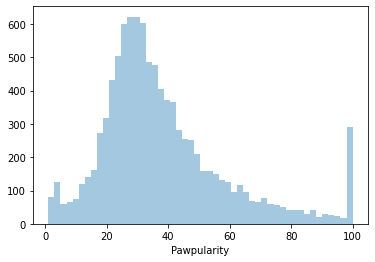

In [18]:
sns.distplot(train["Pawpularity"], kde=False)

# Preprocess

In [19]:
def get_transforms(*, data):
    if data == "train":
        if "basic aug" in wandb_tags:
            return A.Compose(
                [
                    # A.Resize(config.size, config.size),
                    A.RandomResizedCrop(config.size, config.size),
                    A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(p=0.5),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2(),
                ]
            )

        if "heavy aug" in wandb_tags:
            return A.Compose(
                [
                    # A.Resize(config.size, config.size),
                    A.RandomResizedCrop(config.size, config.size),
                    A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(p=0.5),
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                    # A.CoarseDropout(p=0.5),
                    # A.Cutout(p=0.5),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2(),
                ]
            )

    return A.Compose(
        [
            A.Resize(config.size, config.size),
            # A.CenterCrop(config.size, config.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ]
    )

# EDA 2

# 👑 Load Artifacts

In [20]:
if Config.debug:
    train = train.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
    if len(sub) > Config.num_debug_data:
        test = test.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
        sub = sub.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)

# Utils

In [21]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)

# Make Fold

In [22]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train.loc[:, "bins"] = pd.cut(train["Pawpularity"], bins=num_bins, labels=False)

In [23]:
Fold = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.int8)
print(train.groupby(["fold", "bins"]).size())

fold  bins
0     0        33
      1        42
      2       111
      3       203
      4       188
             ... 
9     9        28
      10       20
      11       14
      12       11
      13       36
Length: 140, dtype: int64


# Dataset

In [24]:
# https://github.com/yuhao318/mwh/blob/main/utils.py
def mixup(x, feats, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_feats = lam * feats + (1 - lam) * feats[index]
    y_a, y_b = y, y[index]

    # return mixed_image, mixed_label, lam
    return mixed_x, mixed_feats, y_a, y_b, lam

In [25]:
class BaseDataset(Dataset):
    def __init__(self, df, transform=None, label=True):
        self.df = df
        self.file_names = df["Id"].values
        self.features = df.drop(["Id", "Pawpularity", "fold", "bins"], axis=1).values
        self.transform = transform

        self.use_label = label
        if self.use_label:
            self.path = TRAIN_IMAGE_PATH
            self.labels = df["Pawpularity"].values / 100.0
        else:
            self.path = TEST_IMAGE_PATH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{self.path}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        feature = torch.tensor(self.features[idx])
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        if self.use_label:
            label = torch.tensor(self.labels[idx])
            return image, feature, label
        return image, feature

In [26]:
if Config.debug:
    train_ds = BaseDataset(train)
    image, feature, label = train_ds[0]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

In [27]:
if Config.debug:
    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    image, feature, label = train_ds[0]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# 🚗 Model

In [28]:
class BaseModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, 128)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, 128)

        elif any(key in model_name for key in ["vit", "swin"]):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, 128)

        self.dropout = nn.Dropout(0.1)
        self.head1 = nn.Linear(140, 64)
        self.head2 = nn.Linear(64, config.n_class)

    @amp.autocast(enabled=Config.amp)
    def forward(self, x, feats):
        x = self.model(x)
        x = self.dropout(x)
        x = torch.cat([x, feats], dim=1)
        x = self.head1(x)
        x = self.head2(x)
        return x

In [29]:
def train_mode(model):
    model.train()

    # Freeze layer normalization
    if any(key in config.model_name for key in ["vit", "swin"]):
        for m in model.modules():
            for child in m.children():
                if isinstance(child, nn.LayerNorm):
                    for param in child.parameters():
                        param.requires_grad = False

In [30]:
if Config.debug and config.model_name != "":
    model = BaseModel(config.model_name)
    model.apply(train_mode)

    for n, (name, tensor) in enumerate(list(model.named_parameters())):
        print(f"{n:>4}: {tensor.requires_grad}, {name}")

In [31]:
if Config.debug and config.model_name != "":
    model = BaseModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        output = model(image, feature)
        print(output)
        break

In [32]:
if Config.debug and config.model_name != "":
    model = BaseModel(config.model_name)
    # print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        image, feature, label_a, label_b, lam = mixup(image, feature, label, alpha=0.5)

        plt.imshow(image[0].permute(1, 2, 0))
        plt.title(f"label: {label_a} and {label_b}")
        plt.show()

        output = model(image, feature)
        print(output)
        break

# Optimizer

# Loss

In [33]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Scoring

In [34]:
def get_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [35]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["Pawpularity"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    if fold == config.n_fold:
        wandb.log({"Score": score})
    else:
        wandb.log({f"Score_fold{fold}": score})

# Helper functions

In [36]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [37]:
# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_preds = None

    def __call__(self, val_loss, score, model, preds):

        if self.best_score is None:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
        elif val_loss >= self.val_loss_min + self.delta and self.patience > 0:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [38]:
def compute_grad_norm(parameters, norm_type=2.0):
    """Refer to torch.nn.utils.clip_grad_norm_"""
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type
    total_norm = total_norm ** (1.0 / norm_type)
    return total_norm

In [39]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device):
    losses = AverageMeter()

    # switch to train mode
    if "freeze norm" in wandb_tags:
        model.apply(train_mode)
    else:
        model.train()
    start = time.time()
    optimizer.zero_grad()

    for step, (images, features, labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        if epoch < 2 or epoch >= config.epochs - 2:
            mix_decision = 1.0
        else:
            mix_decision = np.random.rand()

        if epoch >= config.epochs - 5:
            mix_decision *= 2

        if "mixup" in wandb_tags and mix_decision < 0.5:
            images, features, label_a, label_b, lam = mixup(images, features, labels, alpha=0.5)

        with amp.autocast(enabled=Config.amp):
            # y_preds = model(images, features)
            y_preds = model(images, features).squeeze(1)

            if "mixup" in wandb_tags and mix_decision < 0.5:
                loss = criterion(y_preds, label_a) * lam + criterion(y_preds, label_b) * (1.0 - lam)
            else:
                loss = criterion(y_preds, labels)

            losses.update(loss.item(), batch_size)
            loss = loss / config.gradient_accumulation_steps

        scaler.scale(loss).backward()

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()
            optimizer.zero_grad()
        else:
            grad_norm = compute_grad_norm(model.parameters())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_lr()[0]:.6f}  "
            )

    return losses.avg

In [40]:
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, features, labels) in enumerate(valid_loader):
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            # y_preds = model(images, features)
            y_preds = model(images, features).squeeze(1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Postprocess

# 🏃‍♂️ Train loop

In [41]:
def train_loop(df, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_ = BaseDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_ = DataLoader(
        train_dataset_,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "AdamW":
            optimizer = T.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer, train_dataset):
        num_data = len(train_dataset)
        num_steps = num_data // (config.batch_size * config.gradient_accumulation_steps) * config.epochs

        if config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=num_steps, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=num_steps, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=num_steps,
                max_lr=config.lr,
                min_lr=config.min_lr,
                warmup_steps=(num_steps // 10),
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(config.model_name)
    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    optimizer = get_optimizer(model)
    scaler = amp.GradScaler(enabled=Config.amp)
    scheduler = get_scheduler(optimizer, train_dataset)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Early stopping
    # ====================================================
    es = EarlyStopping(
        patience=config.es_patience,
        verbose=True,
        path=MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth",
    )

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf
    best_preds = None

    for epoch in range(config.epochs):
        start_time = time.time()

        # train
        if epoch < 2 or epoch >= config.epochs - 2:
            avg_loss = train_fn(train_loader_, model, criterion, optimizer, scheduler, scaler, epoch, device)
        else:
            avg_loss = train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["Pawpularity"].values

        if config.criterion == "BCEWithLogitsLoss":
            preds = 1 / (1 + np.exp(-preds))

        preds *= 100.0

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/valid_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        es(avg_val_loss, score, model, preds)

        if es.early_stop:
            print("Early stopping")
            break

    # valid_folds[[str(c) for c in range(config.n_class)]] = es.best_preds
    # valid_folds["preds"] = es.best_preds.argmax(1)
    valid_folds["preds"] = es.best_preds

    return valid_folds, es.best_score, es.val_loss_min

# Main function

In [42]:
def main():
    # ====================================================
    # Training
    # ====================================================
    if Config.train:
        oof_df = pd.DataFrame()
        oof_result = []
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df, score, loss = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            oof_result.append([fold, score, loss])

            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)

        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)

        loss = statistics.mean([d[2] for d in oof_result])
        wandb.log({"loss": loss})

        table = wandb.Table(data=oof_result, columns=["fold", "score", "loss"])
        run.log({"Fold Result": table})

        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(config.model_name, type="model")
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)

# 🚀 Run

In [43]:
main()

========== fold: 0 training ==========


Epoch: [1][0/139] Elapsed 0m 26s (remain 60m 40s) Loss: 0.6972 Grad: 0.6308 LR: 0.000010  
Epoch: [1][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6563 Grad: 0.2361 LR: 0.000010  
Epoch: [1][138/139] Elapsed 2m 2s (remain 0m 0s) Loss: 0.6533 Grad: 0.2595 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6634 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6456 


Epoch 1 - avg_train_loss: 0.6533  avg_val_loss: 0.6456  time: 132s
Epoch 1 - Score: 18.139214748341793


Validation loss decreased (inf --> 0.645584).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 6m 58s) Loss: 0.6445 Grad: 0.2588 LR: 0.000010  
Epoch: [2][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6394 Grad: 0.5006 LR: 0.000009  
Epoch: [2][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6391 Grad: 0.4055 LR: 0.000009  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 36s) Loss: 0.6622 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6416 


Epoch 2 - avg_train_loss: 0.6391  avg_val_loss: 0.6416  time: 109s
Epoch 2 - Score: 17.597479635035725


Validation loss decreased (0.645584 --> 0.641574).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 2s (remain 6m 53s) Loss: 0.6423 Grad: 0.8749 LR: 0.000009  
Epoch: [3][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6485 Grad: 0.6389 LR: 0.000008  
Epoch: [3][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6489 Grad: 0.4619 LR: 0.000008  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6687 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6445 


Epoch 3 - avg_train_loss: 0.6489  avg_val_loss: 0.6445  time: 110s
Epoch 3 - Score: 17.93805252532811


EarlyStopping counter: 1 out of 10
Epoch: [4][0/139] Elapsed 0m 3s (remain 7m 32s) Loss: 0.6477 Grad: 0.5019 LR: 0.000008  
Epoch: [4][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6483 Grad: 0.6314 LR: 0.000007  
Epoch: [4][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6475 Grad: 0.6110 LR: 0.000007  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 35s) Loss: 0.6644 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6413 


Epoch 4 - avg_train_loss: 0.6475  avg_val_loss: 0.6413  time: 110s
Epoch 4 - Score: 17.54785432631126


Validation loss decreased (0.641574 --> 0.641260).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 3s (remain 7m 41s) Loss: 0.6551 Grad: 0.6845 LR: 0.000007  
Epoch: [5][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6464 Grad: 0.6053 LR: 0.000006  
Epoch: [5][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6466 Grad: 0.4863 LR: 0.000005  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 36s) Loss: 0.6638 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6431 


Epoch 5 - avg_train_loss: 0.6466  avg_val_loss: 0.6431  time: 111s
Epoch 5 - Score: 17.76088711748791


EarlyStopping counter: 1 out of 10
Epoch: [6][0/139] Elapsed 0m 3s (remain 7m 27s) Loss: 0.6476 Grad: 0.4662 LR: 0.000005  
Epoch: [6][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6438 Grad: 0.4155 LR: 0.000004  
Epoch: [6][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6425 Grad: 0.5817 LR: 0.000004  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6638 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6433 


Epoch 6 - avg_train_loss: 0.6425  avg_val_loss: 0.6433  time: 111s
Epoch 6 - Score: 17.75139029091601


EarlyStopping counter: 2 out of 10
Epoch: [7][0/139] Elapsed 0m 3s (remain 7m 22s) Loss: 0.6297 Grad: 1.0415 LR: 0.000004  
Epoch: [7][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6420 Grad: 0.6541 LR: 0.000003  
Epoch: [7][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6421 Grad: 0.4950 LR: 0.000003  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6631 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6420 


Epoch 7 - avg_train_loss: 0.6421  avg_val_loss: 0.6420  time: 111s
Epoch 7 - Score: 17.611071540834043


EarlyStopping counter: 3 out of 10
Epoch: [8][0/139] Elapsed 0m 2s (remain 6m 53s) Loss: 0.6151 Grad: 0.5378 LR: 0.000003  
Epoch: [8][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6417 Grad: 0.7243 LR: 0.000002  
Epoch: [8][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6414 Grad: 0.5660 LR: 0.000002  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6640 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6411 


Epoch 8 - avg_train_loss: 0.6414  avg_val_loss: 0.6411  time: 111s
Epoch 8 - Score: 17.508974908298274


Validation loss decreased (0.641260 --> 0.641060).  Saving model ...
Epoch: [9][0/139] Elapsed 0m 2s (remain 6m 47s) Loss: 0.6459 Grad: 0.8599 LR: 0.000002  
Epoch: [9][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6275 Grad: 0.5311 LR: 0.000001  
Epoch: [9][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6272 Grad: 0.8207 LR: 0.000001  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 34s) Loss: 0.6617 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6413 


Epoch 9 - avg_train_loss: 0.6272  avg_val_loss: 0.6413  time: 109s
Epoch 9 - Score: 17.520238938859244


EarlyStopping counter: 1 out of 10
Epoch: [10][0/139] Elapsed 0m 2s (remain 6m 37s) Loss: 0.6217 Grad: 0.7089 LR: 0.000001  
Epoch: [10][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6252 Grad: 0.3903 LR: 0.000001  
Epoch: [10][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6259 Grad: 0.5062 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6617 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6418 


Epoch 10 - avg_train_loss: 0.6259  avg_val_loss: 0.6418  time: 110s
Epoch 10 - Score: 17.56913871304037
========== fold: 0 result ==========
Score: 17.50897
========== fold: 1 training ==========


EarlyStopping counter: 2 out of 10
Epoch: [1][0/139] Elapsed 0m 3s (remain 7m 7s) Loss: 0.6991 Grad: 0.5142 LR: 0.000010  
Epoch: [1][100/139] Elapsed 1m 12s (remain 0m 27s) Loss: 0.6555 Grad: 0.3400 LR: 0.000010  
Epoch: [1][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6528 Grad: 0.3144 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6324 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6417 


Epoch 1 - avg_train_loss: 0.6528  avg_val_loss: 0.6417  time: 109s
Epoch 1 - Score: 17.877884053655954


Validation loss decreased (inf --> 0.641654).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 6m 46s) Loss: 0.6331 Grad: 0.2600 LR: 0.000010  
Epoch: [2][100/139] Elapsed 1m 12s (remain 0m 27s) Loss: 0.6394 Grad: 0.4233 LR: 0.000009  
Epoch: [2][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6388 Grad: 0.3587 LR: 0.000009  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6282 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6386 


Epoch 2 - avg_train_loss: 0.6388  avg_val_loss: 0.6386  time: 109s
Epoch 2 - Score: 17.466903167121703


Validation loss decreased (0.641654 --> 0.638602).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 7m 39s) Loss: 0.6375 Grad: 1.0733 LR: 0.000009  
Epoch: [3][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6476 Grad: 0.6674 LR: 0.000008  
Epoch: [3][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6474 Grad: 0.6528 LR: 0.000008  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6280 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6383 


Epoch 3 - avg_train_loss: 0.6474  avg_val_loss: 0.6383  time: 111s
Epoch 3 - Score: 17.4262092865963


Validation loss decreased (0.638602 --> 0.638297).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 3s (remain 7m 44s) Loss: 0.6572 Grad: 0.4973 LR: 0.000008  
Epoch: [4][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6484 Grad: 0.5422 LR: 0.000007  
Epoch: [4][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6483 Grad: 0.6660 LR: 0.000007  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6305 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6376 


Epoch 4 - avg_train_loss: 0.6483  avg_val_loss: 0.6376  time: 111s
Epoch 4 - Score: 17.35242116754598


Validation loss decreased (0.638297 --> 0.637644).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 3s (remain 7m 54s) Loss: 0.6662 Grad: 0.6432 LR: 0.000007  
Epoch: [5][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6451 Grad: inf LR: 0.000006  
Epoch: [5][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6461 Grad: 0.5484 LR: 0.000005  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6290 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6376 


Epoch 5 - avg_train_loss: 0.6461  avg_val_loss: 0.6376  time: 111s
Epoch 5 - Score: 17.334475213830896


Validation loss decreased (0.637644 --> 0.637559).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 3s (remain 7m 58s) Loss: 0.6227 Grad: 0.6028 LR: 0.000005  
Epoch: [6][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6442 Grad: 0.5079 LR: 0.000004  
Epoch: [6][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6435 Grad: 0.5525 LR: 0.000004  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6289 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6376 


Epoch 6 - avg_train_loss: 0.6435  avg_val_loss: 0.6376  time: 112s
Epoch 6 - Score: 17.330945365556158


EarlyStopping counter: 1 out of 10
Epoch: [7][0/139] Elapsed 0m 3s (remain 7m 38s) Loss: 0.6476 Grad: 0.6016 LR: 0.000004  
Epoch: [7][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6397 Grad: 0.4728 LR: 0.000003  
Epoch: [7][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6410 Grad: 0.4756 LR: 0.000003  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6285 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6379 


Epoch 7 - avg_train_loss: 0.6410  avg_val_loss: 0.6379  time: 111s
Epoch 7 - Score: 17.36874073643237


EarlyStopping counter: 2 out of 10
Epoch: [8][0/139] Elapsed 0m 3s (remain 7m 39s) Loss: 0.6684 Grad: 0.8052 LR: 0.000003  
Epoch: [8][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6412 Grad: 0.6274 LR: 0.000002  
Epoch: [8][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6409 Grad: 2.2095 LR: 0.000002  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 36s) Loss: 0.6280 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6376 


Epoch 8 - avg_train_loss: 0.6409  avg_val_loss: 0.6376  time: 111s
Epoch 8 - Score: 17.329560824564794


EarlyStopping counter: 3 out of 10
Epoch: [9][0/139] Elapsed 0m 3s (remain 7m 0s) Loss: 0.6318 Grad: 0.3101 LR: 0.000002  
Epoch: [9][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6281 Grad: 0.4194 LR: 0.000001  
Epoch: [9][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6275 Grad: 0.5941 LR: 0.000001  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6272 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6377 


Epoch 9 - avg_train_loss: 0.6275  avg_val_loss: 0.6377  time: 110s
Epoch 9 - Score: 17.342652652151678


EarlyStopping counter: 4 out of 10
Epoch: [10][0/139] Elapsed 0m 2s (remain 6m 40s) Loss: 0.6200 Grad: 0.3646 LR: 0.000001  
Epoch: [10][100/139] Elapsed 1m 12s (remain 0m 27s) Loss: 0.6273 Grad: 0.6242 LR: 0.000001  
Epoch: [10][138/139] Elapsed 1m 38s (remain 0m 0s) Loss: 0.6265 Grad: 0.3083 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6262 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6381 


Epoch 10 - avg_train_loss: 0.6265  avg_val_loss: 0.6381  time: 109s
Epoch 10 - Score: 17.377878260094903
========== fold: 1 result ==========
Score: 17.33448
========== fold: 2 training ==========


EarlyStopping counter: 5 out of 10
Epoch: [1][0/139] Elapsed 0m 3s (remain 7m 10s) Loss: 0.6780 Grad: 0.6156 LR: 0.000010  
Epoch: [1][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6542 Grad: 0.3123 LR: 0.000010  
Epoch: [1][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6523 Grad: 0.3142 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6380 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6454 


Epoch 1 - avg_train_loss: 0.6523  avg_val_loss: 0.6454  time: 110s
Epoch 1 - Score: 18.40701133289062


Validation loss decreased (inf --> 0.645409).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 6m 50s) Loss: 0.6214 Grad: 0.3401 LR: 0.000010  
Epoch: [2][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6393 Grad: 0.6370 LR: 0.000009  
Epoch: [2][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6389 Grad: 0.4934 LR: 0.000009  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6406 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6480 


Epoch 2 - avg_train_loss: 0.6389  avg_val_loss: 0.6480  time: 110s
Epoch 2 - Score: 18.682260679352343


EarlyStopping counter: 1 out of 10
Epoch: [3][0/139] Elapsed 0m 3s (remain 7m 26s) Loss: 0.6649 Grad: 0.7885 LR: 0.000009  
Epoch: [3][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6503 Grad: 0.7341 LR: 0.000008  
Epoch: [3][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6496 Grad: 0.6478 LR: 0.000008  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6405 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6435 


Epoch 3 - avg_train_loss: 0.6496  avg_val_loss: 0.6435  time: 111s
Epoch 3 - Score: 18.183114897712212


Validation loss decreased (0.645409 --> 0.643506).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 3s (remain 7m 10s) Loss: 0.6389 Grad: 1.9688 LR: 0.000008  
Epoch: [4][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6472 Grad: 1.0712 LR: 0.000007  
Epoch: [4][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6468 Grad: 0.6041 LR: 0.000007  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6408 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6443 


Epoch 4 - avg_train_loss: 0.6468  avg_val_loss: 0.6443  time: 111s
Epoch 4 - Score: 18.2616661748941


EarlyStopping counter: 1 out of 10
Epoch: [5][0/139] Elapsed 0m 3s (remain 7m 28s) Loss: 0.6522 Grad: 0.7224 LR: 0.000007  
Epoch: [5][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6468 Grad: 0.4768 LR: 0.000006  
Epoch: [5][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6454 Grad: 0.4337 LR: 0.000005  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6425 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6445 


Epoch 5 - avg_train_loss: 0.6454  avg_val_loss: 0.6445  time: 111s
Epoch 5 - Score: 18.28981719605867


EarlyStopping counter: 2 out of 10
Epoch: [6][0/139] Elapsed 0m 3s (remain 7m 34s) Loss: 0.6355 Grad: 0.6583 LR: 0.000005  
Epoch: [6][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6424 Grad: 1.1177 LR: 0.000004  
Epoch: [6][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6435 Grad: 0.9447 LR: 0.000004  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6427 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6445 


Epoch 6 - avg_train_loss: 0.6435  avg_val_loss: 0.6445  time: 111s
Epoch 6 - Score: 18.311137087590794


EarlyStopping counter: 3 out of 10
Epoch: [7][0/139] Elapsed 0m 3s (remain 8m 5s) Loss: 0.6602 Grad: 0.9499 LR: 0.000004  
Epoch: [7][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6437 Grad: 0.4982 LR: 0.000003  
Epoch: [7][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6427 Grad: 0.6527 LR: 0.000003  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6433 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6447 


Epoch 7 - avg_train_loss: 0.6427  avg_val_loss: 0.6447  time: 111s
Epoch 7 - Score: 18.332917531818616


EarlyStopping counter: 4 out of 10
Epoch: [8][0/139] Elapsed 0m 3s (remain 7m 28s) Loss: 0.6535 Grad: 1.5713 LR: 0.000003  
Epoch: [8][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6407 Grad: 0.6908 LR: 0.000002  
Epoch: [8][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6408 Grad: 0.9784 LR: 0.000002  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6435 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6447 


Epoch 8 - avg_train_loss: 0.6408  avg_val_loss: 0.6447  time: 111s
Epoch 8 - Score: 18.33586807880988


EarlyStopping counter: 5 out of 10
Epoch: [9][0/139] Elapsed 0m 2s (remain 6m 53s) Loss: 0.6518 Grad: 0.4833 LR: 0.000002  
Epoch: [9][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6274 Grad: 0.4848 LR: 0.000001  
Epoch: [9][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6277 Grad: 0.4657 LR: 0.000001  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6419 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6445 


Epoch 9 - avg_train_loss: 0.6277  avg_val_loss: 0.6445  time: 110s
Epoch 9 - Score: 18.298985280173145


EarlyStopping counter: 6 out of 10
Epoch: [10][0/139] Elapsed 0m 3s (remain 7m 19s) Loss: 0.6274 Grad: 0.3736 LR: 0.000001  
Epoch: [10][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6249 Grad: 0.4355 LR: 0.000001  
Epoch: [10][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6261 Grad: 0.5042 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6441 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6449 


Epoch 10 - avg_train_loss: 0.6261  avg_val_loss: 0.6449  time: 110s
Epoch 10 - Score: 18.360188252217913
========== fold: 2 result ==========
Score: 18.18311
========== fold: 3 training ==========


EarlyStopping counter: 7 out of 10
Epoch: [1][0/139] Elapsed 0m 3s (remain 7m 6s) Loss: 0.6949 Grad: 0.6537 LR: 0.000010  
Epoch: [1][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6542 Grad: 0.3221 LR: 0.000010  
Epoch: [1][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6523 Grad: 0.4514 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6419 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6408 


Epoch 1 - avg_train_loss: 0.6523  avg_val_loss: 0.6408  time: 110s
Epoch 1 - Score: 17.618470104781846


Validation loss decreased (inf --> 0.640781).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 7m 22s) Loss: 0.6426 Grad: 0.3552 LR: 0.000010  
Epoch: [2][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6399 Grad: 0.3866 LR: 0.000009  
Epoch: [2][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6393 Grad: 0.4891 LR: 0.000009  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6424 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6378 


Epoch 2 - avg_train_loss: 0.6393  avg_val_loss: 0.6378  time: 110s
Epoch 2 - Score: 17.218517987470673


Validation loss decreased (0.640781 --> 0.637850).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 7m 27s) Loss: 0.6495 Grad: 0.4330 LR: 0.000009  
Epoch: [3][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6511 Grad: 0.9887 LR: 0.000008  
Epoch: [3][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6501 Grad: 0.7111 LR: 0.000008  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6408 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6370 


Epoch 3 - avg_train_loss: 0.6501  avg_val_loss: 0.6370  time: 111s
Epoch 3 - Score: 17.10945376233432


Validation loss decreased (0.637850 --> 0.636975).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 3s (remain 7m 47s) Loss: 0.6517 Grad: 0.4907 LR: 0.000008  
Epoch: [4][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6467 Grad: 0.8838 LR: 0.000007  
Epoch: [4][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6470 Grad: 0.7948 LR: 0.000007  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6413 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6358 


Epoch 4 - avg_train_loss: 0.6470  avg_val_loss: 0.6358  time: 111s
Epoch 4 - Score: 16.948705360863293


Validation loss decreased (0.636975 --> 0.635758).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 3s (remain 7m 40s) Loss: 0.6572 Grad: 8.5581 LR: 0.000007  
Epoch: [5][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6448 Grad: 0.8170 LR: 0.000006  
Epoch: [5][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6451 Grad: 0.7756 LR: 0.000005  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6403 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6363 


Epoch 5 - avg_train_loss: 0.6451  avg_val_loss: 0.6363  time: 111s
Epoch 5 - Score: 17.026549946737187


EarlyStopping counter: 1 out of 10
Epoch: [6][0/139] Elapsed 0m 3s (remain 7m 20s) Loss: 0.6225 Grad: 0.4038 LR: 0.000005  
Epoch: [6][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6420 Grad: 0.5716 LR: 0.000004  
Epoch: [6][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6433 Grad: 0.8061 LR: 0.000004  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6426 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6367 


Epoch 6 - avg_train_loss: 0.6433  avg_val_loss: 0.6367  time: 110s
Epoch 6 - Score: 17.080622652405093


EarlyStopping counter: 2 out of 10
Epoch: [7][0/139] Elapsed 0m 3s (remain 7m 42s) Loss: 0.6277 Grad: 0.6313 LR: 0.000004  
Epoch: [7][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6409 Grad: 0.9232 LR: 0.000003  
Epoch: [7][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6411 Grad: 0.6795 LR: 0.000003  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6434 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6369 


Epoch 7 - avg_train_loss: 0.6411  avg_val_loss: 0.6369  time: 111s
Epoch 7 - Score: 17.094611328197658


EarlyStopping counter: 3 out of 10
Epoch: [8][0/139] Elapsed 0m 3s (remain 7m 13s) Loss: 0.6128 Grad: 0.6315 LR: 0.000003  
Epoch: [8][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6412 Grad: 0.6568 LR: 0.000002  
Epoch: [8][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6414 Grad: 0.4925 LR: 0.000002  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6428 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6370 


Epoch 8 - avg_train_loss: 0.6414  avg_val_loss: 0.6370  time: 110s
Epoch 8 - Score: 17.112542378247774


EarlyStopping counter: 4 out of 10
Epoch: [9][0/139] Elapsed 0m 2s (remain 6m 53s) Loss: 0.6139 Grad: 0.3280 LR: 0.000002  
Epoch: [9][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6283 Grad: 0.4611 LR: 0.000001  
Epoch: [9][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6280 Grad: 0.3362 LR: 0.000001  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6424 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6366 


Epoch 9 - avg_train_loss: 0.6280  avg_val_loss: 0.6366  time: 110s
Epoch 9 - Score: 17.058270258716163


EarlyStopping counter: 5 out of 10
Epoch: [10][0/139] Elapsed 0m 3s (remain 7m 19s) Loss: 0.6197 Grad: 0.8431 LR: 0.000001  
Epoch: [10][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6262 Grad: 0.5063 LR: 0.000001  
Epoch: [10][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6265 Grad: 0.5613 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6422 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6363 


Epoch 10 - avg_train_loss: 0.6265  avg_val_loss: 0.6363  time: 110s
Epoch 10 - Score: 17.022747347575745
========== fold: 3 result ==========
Score: 16.94871
========== fold: 4 training ==========


EarlyStopping counter: 6 out of 10
Epoch: [1][0/139] Elapsed 0m 3s (remain 7m 19s) Loss: 0.6948 Grad: 0.5010 LR: 0.000010  
Epoch: [1][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6552 Grad: 0.2974 LR: 0.000010  
Epoch: [1][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6518 Grad: 0.3051 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6462 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6452 


Epoch 1 - avg_train_loss: 0.6518  avg_val_loss: 0.6452  time: 110s
Epoch 1 - Score: 18.367491281965492


Validation loss decreased (inf --> 0.645191).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 6m 53s) Loss: 0.6594 Grad: 0.4184 LR: 0.000010  
Epoch: [2][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6385 Grad: 0.2948 LR: 0.000009  
Epoch: [2][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6379 Grad: 0.3460 LR: 0.000009  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6470 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6434 


Epoch 2 - avg_train_loss: 0.6379  avg_val_loss: 0.6434  time: 110s
Epoch 2 - Score: 18.132826210270647


Validation loss decreased (0.645191 --> 0.643427).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 8m 1s) Loss: 0.6416 Grad: 0.3874 LR: 0.000009  
Epoch: [3][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6483 Grad: 0.5131 LR: 0.000008  
Epoch: [3][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6495 Grad: 0.6765 LR: 0.000008  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6421 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6434 


Epoch 3 - avg_train_loss: 0.6495  avg_val_loss: 0.6434  time: 111s
Epoch 3 - Score: 18.14493279791945


Validation loss decreased (0.643427 --> 0.643361).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 3s (remain 7m 20s) Loss: 0.6380 Grad: 0.9131 LR: 0.000008  
Epoch: [4][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6453 Grad: 0.6754 LR: 0.000007  
Epoch: [4][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6455 Grad: 0.5688 LR: 0.000007  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6398 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6431 


Epoch 4 - avg_train_loss: 0.6455  avg_val_loss: 0.6431  time: 111s
Epoch 4 - Score: 18.102330341034452


Validation loss decreased (0.643361 --> 0.643113).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 3s (remain 7m 26s) Loss: 0.6595 Grad: 1.3676 LR: 0.000007  
Epoch: [5][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6465 Grad: 0.5305 LR: 0.000006  
Epoch: [5][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6464 Grad: 0.5410 LR: 0.000005  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6408 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6442 


Epoch 5 - avg_train_loss: 0.6464  avg_val_loss: 0.6442  time: 110s
Epoch 5 - Score: 18.221708643416182


EarlyStopping counter: 1 out of 10
Epoch: [6][0/139] Elapsed 0m 3s (remain 7m 42s) Loss: 0.6493 Grad: 0.4321 LR: 0.000005  
Epoch: [6][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6412 Grad: 1.2961 LR: 0.000004  
Epoch: [6][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6413 Grad: 1.1116 LR: 0.000004  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6403 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6440 


Epoch 6 - avg_train_loss: 0.6413  avg_val_loss: 0.6440  time: 111s
Epoch 6 - Score: 18.203985771301124


EarlyStopping counter: 2 out of 10
Epoch: [7][0/139] Elapsed 0m 3s (remain 8m 21s) Loss: 0.6438 Grad: 0.4015 LR: 0.000004  
Epoch: [7][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6406 Grad: 0.6921 LR: 0.000003  
Epoch: [7][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6410 Grad: 0.4894 LR: 0.000003  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6418 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6443 


Epoch 7 - avg_train_loss: 0.6410  avg_val_loss: 0.6443  time: 111s
Epoch 7 - Score: 18.242142334690747


EarlyStopping counter: 3 out of 10
Epoch: [8][0/139] Elapsed 0m 3s (remain 7m 31s) Loss: 0.6302 Grad: 0.5945 LR: 0.000003  
Epoch: [8][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6404 Grad: 0.6860 LR: 0.000002  
Epoch: [8][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6407 Grad: 0.4315 LR: 0.000002  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6408 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6441 


Epoch 8 - avg_train_loss: 0.6407  avg_val_loss: 0.6441  time: 111s
Epoch 8 - Score: 18.22550764986953


EarlyStopping counter: 4 out of 10
Epoch: [9][0/139] Elapsed 0m 3s (remain 7m 1s) Loss: 0.6311 Grad: 0.4102 LR: 0.000002  
Epoch: [9][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6275 Grad: 0.6312 LR: 0.000001  
Epoch: [9][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6268 Grad: 0.3885 LR: 0.000001  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6419 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6440 


Epoch 9 - avg_train_loss: 0.6268  avg_val_loss: 0.6440  time: 110s
Epoch 9 - Score: 18.2004773618786


EarlyStopping counter: 5 out of 10
Epoch: [10][0/139] Elapsed 0m 3s (remain 6m 56s) Loss: 0.6237 Grad: 0.4798 LR: 0.000001  
Epoch: [10][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6249 Grad: 0.5839 LR: 0.000001  
Epoch: [10][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6251 Grad: 0.3160 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6435 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6440 


Epoch 10 - avg_train_loss: 0.6251  avg_val_loss: 0.6440  time: 110s
Epoch 10 - Score: 18.20277425410125
========== fold: 4 result ==========
Score: 18.10233
========== fold: 5 training ==========


EarlyStopping counter: 6 out of 10
Epoch: [1][0/139] Elapsed 0m 3s (remain 7m 3s) Loss: 0.6940 Grad: 0.6761 LR: 0.000010  
Epoch: [1][100/139] Elapsed 1m 12s (remain 0m 27s) Loss: 0.6553 Grad: 0.4403 LR: 0.000010  
Epoch: [1][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6531 Grad: 0.5508 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6529 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6434 


Epoch 1 - avg_train_loss: 0.6531  avg_val_loss: 0.6434  time: 109s
Epoch 1 - Score: 17.853288759488358


Validation loss decreased (inf --> 0.643364).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 6m 45s) Loss: 0.6352 Grad: 0.5538 LR: 0.000010  
Epoch: [2][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6398 Grad: 0.3467 LR: 0.000009  
Epoch: [2][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6392 Grad: 0.4255 LR: 0.000009  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6522 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6403 


Epoch 2 - avg_train_loss: 0.6392  avg_val_loss: 0.6403  time: 110s
Epoch 2 - Score: 17.425172367355174


Validation loss decreased (0.643364 --> 0.640281).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 7m 19s) Loss: 0.6575 Grad: 0.5384 LR: 0.000009  
Epoch: [3][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6499 Grad: 0.5203 LR: 0.000008  
Epoch: [3][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6487 Grad: 0.6730 LR: 0.000008  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6535 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6394 


Epoch 3 - avg_train_loss: 0.6487  avg_val_loss: 0.6394  time: 110s
Epoch 3 - Score: 17.315951561589184


Validation loss decreased (0.640281 --> 0.639392).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 3s (remain 7m 33s) Loss: 0.6489 Grad: 0.7087 LR: 0.000008  
Epoch: [4][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6466 Grad: 0.7918 LR: 0.000007  
Epoch: [4][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6470 Grad: 0.3906 LR: 0.000007  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6536 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6395 


Epoch 4 - avg_train_loss: 0.6470  avg_val_loss: 0.6395  time: 111s
Epoch 4 - Score: 17.32848138661362


EarlyStopping counter: 1 out of 10
Epoch: [5][0/139] Elapsed 0m 3s (remain 7m 27s) Loss: 0.6340 Grad: 0.4297 LR: 0.000007  
Epoch: [5][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6461 Grad: 0.8162 LR: 0.000006  
Epoch: [5][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6462 Grad: 0.5817 LR: 0.000005  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6531 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6386 


Epoch 5 - avg_train_loss: 0.6462  avg_val_loss: 0.6386  time: 111s
Epoch 5 - Score: 17.202680556650115


Validation loss decreased (0.639392 --> 0.638570).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 3s (remain 7m 21s) Loss: 0.6499 Grad: 0.5721 LR: 0.000005  
Epoch: [6][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6446 Grad: 0.3497 LR: 0.000004  
Epoch: [6][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6435 Grad: 0.4241 LR: 0.000004  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6534 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6388 


Epoch 6 - avg_train_loss: 0.6435  avg_val_loss: 0.6388  time: 111s
Epoch 6 - Score: 17.22229073623371


EarlyStopping counter: 1 out of 10
Epoch: [7][0/139] Elapsed 0m 3s (remain 7m 24s) Loss: 0.6377 Grad: 0.3426 LR: 0.000004  
Epoch: [7][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6398 Grad: 0.3970 LR: 0.000003  
Epoch: [7][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6409 Grad: 0.3816 LR: 0.000003  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6536 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6388 


Epoch 7 - avg_train_loss: 0.6409  avg_val_loss: 0.6388  time: 111s
Epoch 7 - Score: 17.232463232130602


EarlyStopping counter: 2 out of 10
Epoch: [8][0/139] Elapsed 0m 3s (remain 7m 19s) Loss: 0.6220 Grad: 0.5683 LR: 0.000003  
Epoch: [8][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6418 Grad: 0.4396 LR: 0.000002  
Epoch: [8][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6413 Grad: 0.4422 LR: 0.000002  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6538 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6383 


Epoch 8 - avg_train_loss: 0.6413  avg_val_loss: 0.6383  time: 111s
Epoch 8 - Score: 17.163029857055086


Validation loss decreased (0.638570 --> 0.638334).  Saving model ...
Epoch: [9][0/139] Elapsed 0m 2s (remain 6m 42s) Loss: 0.6334 Grad: 0.7666 LR: 0.000002  
Epoch: [9][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6285 Grad: 0.4945 LR: 0.000001  
Epoch: [9][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6275 Grad: 0.3205 LR: 0.000001  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6541 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6384 


Epoch 9 - avg_train_loss: 0.6275  avg_val_loss: 0.6384  time: 110s
Epoch 9 - Score: 17.16405395450916


EarlyStopping counter: 1 out of 10
Epoch: [10][0/139] Elapsed 0m 3s (remain 7m 14s) Loss: 0.6280 Grad: 0.4487 LR: 0.000001  
Epoch: [10][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6269 Grad: 0.5227 LR: 0.000001  
Epoch: [10][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6263 Grad: 0.3679 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6544 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6385 


Epoch 10 - avg_train_loss: 0.6263  avg_val_loss: 0.6385  time: 110s
Epoch 10 - Score: 17.192087470300564
========== fold: 5 result ==========
Score: 17.16303
========== fold: 6 training ==========


EarlyStopping counter: 2 out of 10
Epoch: [1][0/139] Elapsed 0m 3s (remain 7m 5s) Loss: 0.6897 Grad: 0.3591 LR: 0.000010  
Epoch: [1][100/139] Elapsed 1m 12s (remain 0m 27s) Loss: 0.6551 Grad: 0.2173 LR: 0.000010  
Epoch: [1][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6531 Grad: 0.3588 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6620 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6447 


Epoch 1 - avg_train_loss: 0.6531  avg_val_loss: 0.6447  time: 109s
Epoch 1 - Score: 18.04629607238654


Validation loss decreased (inf --> 0.644727).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 6m 45s) Loss: 0.6430 Grad: 0.2876 LR: 0.000010  
Epoch: [2][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6397 Grad: 0.5677 LR: 0.000009  
Epoch: [2][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6393 Grad: 0.4927 LR: 0.000009  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6614 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6414 


Epoch 2 - avg_train_loss: 0.6393  avg_val_loss: 0.6414  time: 110s
Epoch 2 - Score: 17.58999273530199


Validation loss decreased (0.644727 --> 0.641433).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 7m 20s) Loss: 0.6502 Grad: 0.6868 LR: 0.000009  
Epoch: [3][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6483 Grad: 1.5048 LR: 0.000008  
Epoch: [3][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6484 Grad: 0.8207 LR: 0.000008  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 36s) Loss: 0.6595 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6408 


Epoch 3 - avg_train_loss: 0.6484  avg_val_loss: 0.6408  time: 110s
Epoch 3 - Score: 17.504763180473986


Validation loss decreased (0.641433 --> 0.640788).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 3s (remain 7m 22s) Loss: 0.6346 Grad: 1.1683 LR: 0.000008  
Epoch: [4][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6464 Grad: 0.6048 LR: 0.000007  
Epoch: [4][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6468 Grad: 0.6523 LR: 0.000007  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6599 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6409 


Epoch 4 - avg_train_loss: 0.6468  avg_val_loss: 0.6409  time: 111s
Epoch 4 - Score: 17.512344931099598


EarlyStopping counter: 1 out of 10
Epoch: [5][0/139] Elapsed 0m 3s (remain 7m 28s) Loss: 0.6374 Grad: 0.5727 LR: 0.000007  
Epoch: [5][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6454 Grad: 0.4762 LR: 0.000006  
Epoch: [5][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6457 Grad: 0.6641 LR: 0.000005  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 36s) Loss: 0.6601 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6408 


Epoch 5 - avg_train_loss: 0.6457  avg_val_loss: 0.6408  time: 110s
Epoch 5 - Score: 17.510588241486303


EarlyStopping counter: 2 out of 10
Epoch: [6][0/139] Elapsed 0m 3s (remain 7m 22s) Loss: 0.6455 Grad: 0.4623 LR: 0.000005  
Epoch: [6][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6427 Grad: 0.5866 LR: 0.000004  
Epoch: [6][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6425 Grad: 0.5178 LR: 0.000004  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6592 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6406 


Epoch 6 - avg_train_loss: 0.6425  avg_val_loss: 0.6406  time: 111s
Epoch 6 - Score: 17.47011601891321


Validation loss decreased (0.640788 --> 0.640578).  Saving model ...
Epoch: [7][0/139] Elapsed 0m 3s (remain 7m 27s) Loss: 0.6511 Grad: 0.6320 LR: 0.000004  
Epoch: [7][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6423 Grad: 0.5083 LR: 0.000003  
Epoch: [7][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6426 Grad: 0.5825 LR: 0.000003  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6577 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6405 


Epoch 7 - avg_train_loss: 0.6426  avg_val_loss: 0.6405  time: 111s
Epoch 7 - Score: 17.453436622910115


Validation loss decreased (0.640578 --> 0.640491).  Saving model ...
Epoch: [8][0/139] Elapsed 0m 3s (remain 7m 5s) Loss: 0.6502 Grad: 0.3860 LR: 0.000003  
Epoch: [8][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6419 Grad: 0.5265 LR: 0.000002  
Epoch: [8][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6418 Grad: 0.5159 LR: 0.000002  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6592 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6407 


Epoch 8 - avg_train_loss: 0.6418  avg_val_loss: 0.6407  time: 111s
Epoch 8 - Score: 17.480074721426387


EarlyStopping counter: 1 out of 10
Epoch: [9][0/139] Elapsed 0m 3s (remain 7m 24s) Loss: 0.5982 Grad: 0.4033 LR: 0.000002  
Epoch: [9][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6293 Grad: 0.3844 LR: 0.000001  
Epoch: [9][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6280 Grad: 0.4901 LR: 0.000001  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6584 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6407 


Epoch 9 - avg_train_loss: 0.6280  avg_val_loss: 0.6407  time: 109s
Epoch 9 - Score: 17.46626554904949


EarlyStopping counter: 2 out of 10
Epoch: [10][0/139] Elapsed 0m 3s (remain 7m 5s) Loss: 0.6388 Grad: 0.5853 LR: 0.000001  
Epoch: [10][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6270 Grad: 0.4331 LR: 0.000001  
Epoch: [10][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6263 Grad: 0.3772 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6579 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6401 


Epoch 10 - avg_train_loss: 0.6263  avg_val_loss: 0.6401  time: 110s
Epoch 10 - Score: 17.39172801777557


Validation loss decreased (0.640491 --> 0.640130).  Saving model ...


========== fold: 6 result ==========
Score: 17.39173
========== fold: 7 training ==========


Epoch: [1][0/139] Elapsed 0m 3s (remain 7m 17s) Loss: 0.6952 Grad: 0.5848 LR: 0.000010  
Epoch: [1][100/139] Elapsed 1m 12s (remain 0m 27s) Loss: 0.6558 Grad: 0.3409 LR: 0.000010  
Epoch: [1][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6528 Grad: 0.3809 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6349 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6481 


Epoch 1 - avg_train_loss: 0.6528  avg_val_loss: 0.6481  time: 110s
Epoch 1 - Score: 18.673765369066217


Validation loss decreased (inf --> 0.648094).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 6m 49s) Loss: 0.6351 Grad: 0.4516 LR: 0.000010  
Epoch: [2][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6385 Grad: 0.5331 LR: 0.000009  
Epoch: [2][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6385 Grad: 0.3535 LR: 0.000009  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6283 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6448 


Epoch 2 - avg_train_loss: 0.6385  avg_val_loss: 0.6448  time: 110s
Epoch 2 - Score: 18.266133762117573


Validation loss decreased (0.648094 --> 0.644839).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 7m 12s) Loss: 0.6375 Grad: 0.7136 LR: 0.000009  
Epoch: [3][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6497 Grad: 0.3890 LR: 0.000008  
Epoch: [3][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6496 Grad: 0.5493 LR: 0.000008  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6307 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6452 


Epoch 3 - avg_train_loss: 0.6496  avg_val_loss: 0.6452  time: 111s
Epoch 3 - Score: 18.30597174920585


EarlyStopping counter: 1 out of 10
Epoch: [4][0/139] Elapsed 0m 3s (remain 7m 36s) Loss: 0.6498 Grad: 0.4864 LR: 0.000008  
Epoch: [4][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6484 Grad: 0.5192 LR: 0.000007  
Epoch: [4][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6476 Grad: 0.5397 LR: 0.000007  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6287 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6451 


Epoch 4 - avg_train_loss: 0.6476  avg_val_loss: 0.6451  time: 111s
Epoch 4 - Score: 18.281896871196306


EarlyStopping counter: 2 out of 10
Epoch: [5][0/139] Elapsed 0m 3s (remain 7m 58s) Loss: 0.6450 Grad: 0.7233 LR: 0.000007  
Epoch: [5][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6435 Grad: 0.5833 LR: 0.000006  
Epoch: [5][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6446 Grad: 0.5828 LR: 0.000005  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6304 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6450 


Epoch 5 - avg_train_loss: 0.6446  avg_val_loss: 0.6450  time: 111s
Epoch 5 - Score: 18.276952259339296


EarlyStopping counter: 3 out of 10
Epoch: [6][0/139] Elapsed 0m 3s (remain 7m 22s) Loss: 0.6399 Grad: 0.5966 LR: 0.000005  
Epoch: [6][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6431 Grad: 0.5024 LR: 0.000004  
Epoch: [6][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6426 Grad: 0.8824 LR: 0.000004  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6306 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6456 


Epoch 6 - avg_train_loss: 0.6426  avg_val_loss: 0.6456  time: 110s
Epoch 6 - Score: 18.36120053535414


EarlyStopping counter: 4 out of 10
Epoch: [7][0/139] Elapsed 0m 3s (remain 7m 42s) Loss: 0.6409 Grad: 0.5871 LR: 0.000004  
Epoch: [7][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6435 Grad: 0.5050 LR: 0.000003  
Epoch: [7][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6420 Grad: 1.2385 LR: 0.000003  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6299 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6453 


Epoch 7 - avg_train_loss: 0.6420  avg_val_loss: 0.6453  time: 110s
Epoch 7 - Score: 18.314074261545606


EarlyStopping counter: 5 out of 10
Epoch: [8][0/139] Elapsed 0m 3s (remain 7m 46s) Loss: 0.6919 Grad: 1.0248 LR: 0.000003  
Epoch: [8][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6408 Grad: 0.7668 LR: 0.000002  
Epoch: [8][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6399 Grad: 0.4347 LR: 0.000002  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6305 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6449 


Epoch 8 - avg_train_loss: 0.6399  avg_val_loss: 0.6449  time: 111s
Epoch 8 - Score: 18.26722266085918


EarlyStopping counter: 6 out of 10
Epoch: [9][0/139] Elapsed 0m 3s (remain 7m 23s) Loss: 0.6203 Grad: 0.4139 LR: 0.000002  
Epoch: [9][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6276 Grad: 0.5315 LR: 0.000001  
Epoch: [9][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6270 Grad: 0.6208 LR: 0.000001  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6309 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6444 


Epoch 9 - avg_train_loss: 0.6270  avg_val_loss: 0.6444  time: 110s
Epoch 9 - Score: 18.198110591798212


Validation loss decreased (0.644839 --> 0.644415).  Saving model ...
Epoch: [10][0/139] Elapsed 0m 3s (remain 7m 22s) Loss: 0.6035 Grad: 0.5284 LR: 0.000001  
Epoch: [10][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6252 Grad: 0.4287 LR: 0.000001  
Epoch: [10][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6257 Grad: 0.3607 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6312 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6450 


Epoch 10 - avg_train_loss: 0.6257  avg_val_loss: 0.6450  time: 110s
Epoch 10 - Score: 18.262032404529574
========== fold: 7 result ==========
Score: 18.19811
========== fold: 8 training ==========


EarlyStopping counter: 1 out of 10
Epoch: [1][0/139] Elapsed 0m 3s (remain 7m 27s) Loss: 0.6972 Grad: 0.5183 LR: 0.000010  
Epoch: [1][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6555 Grad: 0.2362 LR: 0.000010  
Epoch: [1][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6525 Grad: 0.5428 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6380 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6429 


Epoch 1 - avg_train_loss: 0.6525  avg_val_loss: 0.6429  time: 110s
Epoch 1 - Score: 17.969119476414605


Validation loss decreased (inf --> 0.642919).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 7m 56s) Loss: 0.6294 Grad: 0.3932 LR: 0.000010  
Epoch: [2][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6386 Grad: 0.4088 LR: 0.000009  
Epoch: [2][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6396 Grad: 0.4657 LR: 0.000009  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6371 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6404 


Epoch 2 - avg_train_loss: 0.6396  avg_val_loss: 0.6404  time: 111s
Epoch 2 - Score: 17.634800074246115


Validation loss decreased (0.642919 --> 0.640425).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 7m 41s) Loss: 0.6478 Grad: 0.4765 LR: 0.000009  
Epoch: [3][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6501 Grad: 0.4816 LR: 0.000008  
Epoch: [3][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6495 Grad: 0.3722 LR: 0.000008  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6359 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6395 


Epoch 3 - avg_train_loss: 0.6495  avg_val_loss: 0.6395  time: 111s
Epoch 3 - Score: 17.511655974633175


Validation loss decreased (0.640425 --> 0.639465).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 3s (remain 7m 21s) Loss: 0.6451 Grad: 0.5348 LR: 0.000008  
Epoch: [4][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6473 Grad: 0.8353 LR: 0.000007  
Epoch: [4][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6484 Grad: 0.6147 LR: 0.000007  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6369 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6387 


Epoch 4 - avg_train_loss: 0.6484  avg_val_loss: 0.6387  time: 111s
Epoch 4 - Score: 17.40507024473631


Validation loss decreased (0.639465 --> 0.638680).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 3s (remain 8m 9s) Loss: 0.6527 Grad: 0.4976 LR: 0.000007  
Epoch: [5][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6457 Grad: 0.4608 LR: 0.000006  
Epoch: [5][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6459 Grad: 0.4530 LR: 0.000005  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6357 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6392 


Epoch 5 - avg_train_loss: 0.6459  avg_val_loss: 0.6392  time: 112s
Epoch 5 - Score: 17.483789663334953


EarlyStopping counter: 1 out of 10
Epoch: [6][0/139] Elapsed 0m 3s (remain 7m 50s) Loss: 0.6406 Grad: 0.5254 LR: 0.000005  
Epoch: [6][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6427 Grad: 0.7883 LR: 0.000004  
Epoch: [6][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6422 Grad: 0.5085 LR: 0.000004  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6382 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6398 


Epoch 6 - avg_train_loss: 0.6422  avg_val_loss: 0.6398  time: 111s
Epoch 6 - Score: 17.53962037433997


EarlyStopping counter: 2 out of 10
Epoch: [7][0/139] Elapsed 0m 3s (remain 7m 29s) Loss: 0.6670 Grad: 0.6959 LR: 0.000004  
Epoch: [7][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6419 Grad: 1.0637 LR: 0.000003  
Epoch: [7][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6423 Grad: 0.5222 LR: 0.000003  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6413 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6402 


Epoch 7 - avg_train_loss: 0.6423  avg_val_loss: 0.6402  time: 111s
Epoch 7 - Score: 17.587476169563576


EarlyStopping counter: 3 out of 10
Epoch: [8][0/139] Elapsed 0m 3s (remain 7m 53s) Loss: 0.6252 Grad: 0.4702 LR: 0.000003  
Epoch: [8][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6418 Grad: 0.5302 LR: 0.000002  
Epoch: [8][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6418 Grad: 0.5435 LR: 0.000002  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6352 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6387 


Epoch 8 - avg_train_loss: 0.6418  avg_val_loss: 0.6387  time: 112s
Epoch 8 - Score: 17.394892603691137


Validation loss decreased (0.638680 --> 0.638660).  Saving model ...
Epoch: [9][0/139] Elapsed 0m 3s (remain 7m 18s) Loss: 0.6271 Grad: 0.4442 LR: 0.000002  
Epoch: [9][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6275 Grad: 0.5208 LR: 0.000001  
Epoch: [9][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6277 Grad: 0.2958 LR: 0.000001  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6339 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6384 


Epoch 9 - avg_train_loss: 0.6277  avg_val_loss: 0.6384  time: 110s
Epoch 9 - Score: 17.353392941852874


Validation loss decreased (0.638660 --> 0.638380).  Saving model ...
Epoch: [10][0/139] Elapsed 0m 3s (remain 7m 6s) Loss: 0.6235 Grad: 0.3834 LR: 0.000001  
Epoch: [10][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6258 Grad: 0.4950 LR: 0.000001  
Epoch: [10][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6266 Grad: 0.4536 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6327 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6383 


Epoch 10 - avg_train_loss: 0.6266  avg_val_loss: 0.6383  time: 110s
Epoch 10 - Score: 17.34169192074644


Validation loss decreased (0.638380 --> 0.638275).  Saving model ...


========== fold: 8 result ==========
Score: 17.34169
========== fold: 9 training ==========


Epoch: [1][0/139] Elapsed 0m 3s (remain 7m 15s) Loss: 0.6844 Grad: 0.3536 LR: 0.000010  
Epoch: [1][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6538 Grad: 0.7857 LR: 0.000010  
Epoch: [1][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6523 Grad: 0.3699 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6439 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6422 


Epoch 1 - avg_train_loss: 0.6523  avg_val_loss: 0.6422  time: 110s
Epoch 1 - Score: 17.966261008405343


Validation loss decreased (inf --> 0.642201).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 2s (remain 6m 50s) Loss: 0.6526 Grad: 0.3532 LR: 0.000010  
Epoch: [2][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6392 Grad: 0.4295 LR: 0.000009  
Epoch: [2][138/139] Elapsed 1m 39s (remain 0m 0s) Loss: 0.6388 Grad: 0.4087 LR: 0.000009  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6371 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6400 


Epoch 2 - avg_train_loss: 0.6388  avg_val_loss: 0.6400  time: 110s
Epoch 2 - Score: 17.66257251197906


Validation loss decreased (0.642201 --> 0.640007).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 7m 41s) Loss: 0.6335 Grad: 0.5830 LR: 0.000009  
Epoch: [3][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6496 Grad: 0.8805 LR: 0.000008  
Epoch: [3][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6491 Grad: 0.5705 LR: 0.000008  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 39s) Loss: 0.6420 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6396 


Epoch 3 - avg_train_loss: 0.6491  avg_val_loss: 0.6396  time: 111s
Epoch 3 - Score: 17.589866425630284


Validation loss decreased (0.640007 --> 0.639567).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 3s (remain 7m 55s) Loss: 0.6524 Grad: 0.8665 LR: 0.000008  
Epoch: [4][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6463 Grad: 0.3955 LR: 0.000007  
Epoch: [4][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6470 Grad: 0.6781 LR: 0.000007  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6411 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6393 


Epoch 4 - avg_train_loss: 0.6470  avg_val_loss: 0.6393  time: 112s
Epoch 4 - Score: 17.553539469546152


Validation loss decreased (0.639567 --> 0.639327).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 3s (remain 7m 39s) Loss: 0.6358 Grad: 0.5068 LR: 0.000007  
Epoch: [5][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6463 Grad: 0.3871 LR: 0.000006  
Epoch: [5][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6450 Grad: 0.5987 LR: 0.000005  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6421 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6400 


Epoch 5 - avg_train_loss: 0.6450  avg_val_loss: 0.6400  time: 111s
Epoch 5 - Score: 17.625238584601725


EarlyStopping counter: 1 out of 10
Epoch: [6][0/139] Elapsed 0m 3s (remain 8m 7s) Loss: 0.6472 Grad: 0.7821 LR: 0.000005  
Epoch: [6][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6421 Grad: 0.5404 LR: 0.000004  
Epoch: [6][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6426 Grad: 0.5383 LR: 0.000004  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6428 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6396 


Epoch 6 - avg_train_loss: 0.6426  avg_val_loss: 0.6396  time: 112s
Epoch 6 - Score: 17.58011221108336


EarlyStopping counter: 2 out of 10
Epoch: [7][0/139] Elapsed 0m 3s (remain 7m 55s) Loss: 0.6481 Grad: 0.5825 LR: 0.000004  
Epoch: [7][100/139] Elapsed 1m 14s (remain 0m 27s) Loss: 0.6414 Grad: 0.4784 LR: 0.000003  
Epoch: [7][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6420 Grad: 0.5021 LR: 0.000003  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6431 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6405 


Epoch 7 - avg_train_loss: 0.6420  avg_val_loss: 0.6405  time: 111s
Epoch 7 - Score: 17.688324518728358


EarlyStopping counter: 3 out of 10
Epoch: [8][0/139] Elapsed 0m 3s (remain 7m 36s) Loss: 0.6426 Grad: 0.4586 LR: 0.000003  
Epoch: [8][100/139] Elapsed 1m 14s (remain 0m 28s) Loss: 0.6397 Grad: 0.5167 LR: 0.000002  
Epoch: [8][138/139] Elapsed 1m 41s (remain 0m 0s) Loss: 0.6411 Grad: 0.8771 LR: 0.000002  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6407 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6400 


Epoch 8 - avg_train_loss: 0.6411  avg_val_loss: 0.6400  time: 112s
Epoch 8 - Score: 17.648876261467816


EarlyStopping counter: 4 out of 10
Epoch: [9][0/139] Elapsed 0m 2s (remain 6m 53s) Loss: 0.6205 Grad: 0.5694 LR: 0.000002  
Epoch: [9][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6279 Grad: 0.3918 LR: 0.000001  
Epoch: [9][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6274 Grad: 0.2991 LR: 0.000001  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6424 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6402 


Epoch 9 - avg_train_loss: 0.6274  avg_val_loss: 0.6402  time: 110s
Epoch 9 - Score: 17.643427878355595


EarlyStopping counter: 5 out of 10
Epoch: [10][0/139] Elapsed 0m 3s (remain 7m 22s) Loss: 0.6138 Grad: 0.4004 LR: 0.000001  
Epoch: [10][100/139] Elapsed 1m 13s (remain 0m 27s) Loss: 0.6248 Grad: 0.5852 LR: 0.000001  
Epoch: [10][138/139] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6256 Grad: 0.4791 LR: 0.000010  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 38s) Loss: 0.6424 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6405 


Epoch 10 - avg_train_loss: 0.6256  avg_val_loss: 0.6405  time: 110s
Epoch 10 - Score: 17.677793142476272
========== fold: 9 result ==========
Score: 17.55354
========== CV ==========
Score: 17.57751


EarlyStopping counter: 6 out of 10


wandb: Adding directory to artifact (./models)... Done. 13.0s


In [44]:
wandb.finish()

Score,▁
Score_fold0,▁
Score_fold1,▁
Score_fold2,▁
Score_fold3,▁
Score_fold4,▁
Score_fold5,▁
Score_fold6,▁
Score_fold7,▁
Score_fold8,▁
Score_fold9,▁
